In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
import time
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

In [2]:
notebook_start_time = time.time()

In [3]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

############Transform Features###############

##Gender, drop -year, sclact categorical

df["gndr_cat"]=np.where(df["gndr"]==2,1,0)
df["sclact_cat"]= np.where(df["sclact"]>=4,1,0)
df=df.drop(["year","gndr"],1)


# Definine outcome and predictors.
# Set our outcome to 0 and 1.
y = df['partner'] - 1
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]

# Make the categorical variable 'country' into dummies.
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and test sets.
offset = int(X.shape[0] * 0.9)

# Put 90% of the data in the training set.
X_train, y_train = X[:offset], y[:offset]

# And put 10% in the test set.
X_test, y_test = X[offset:], y[offset:]

In [4]:
df.describe()

,idno,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,agea,partner,gndr_cat,sclact_cat
count,8.147000e+03,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000,8147.000000
mean,4.022622e+04,3.818584,5.574936,6.005155,5.321468,7.708482,5.215908,2.755984,47.262182,1.384681,0.496379,0.169510
std,6.320721e+05,2.008937,2.215745,2.120127,2.166217,1.720839,1.438792,0.901406,18.316890,0.486550,0.500018,0.375225
min,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,15.000000,1.000000,0.000000,0.000000
25%,1.063000e+03,2.000000,4.000000,5.000000,4.000000,7.000000,4.000000,2.000000,33.000000,1.000000,0.000000,0.000000
50%,1.749000e+03,4.000000,6.000000,6.000000,5.000000,8.000000,6.000000,3.000000,47.000000,1.000000,0.000000,0.000000
75%,2.778000e+03,5.000000,7.000000,8.000000,7.000000,9.000000,6.000000,3.000000,61.000000,2.000000,1.000000,0.000000
max,1.100143e+07,7.000000,10.000000,10.000000,10.000000,10.000000,7.000000,5.000000,114.000000,2.000000,1.000000,1.000000


In [6]:
df.head()

,cntry,idno,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,agea,partner,gndr_cat,sclact_cat
0,CH,5.0,3.0,3.0,10.0,5.0,8.0,5.0,4.0,60.0,1.0,1,1
1,CH,25.0,6.0,5.0,7.0,5.0,9.0,3.0,2.0,59.0,1.0,1,0
2,CH,26.0,1.0,8.0,8.0,8.0,7.0,6.0,3.0,24.0,2.0,0,0
3,CH,28.0,4.0,6.0,6.0,7.0,10.0,6.0,2.0,64.0,1.0,1,0
4,CH,29.0,5.0,6.0,7.0,5.0,8.0,7.0,2.0,55.0,1.0,1,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017FC2BC7358>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000017FC33668D0>]], dtype=object)

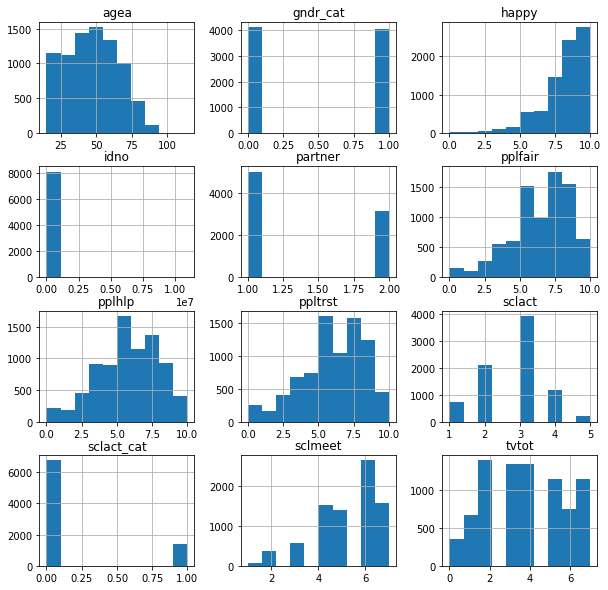

In [7]:
df.hist(figsize=(10,10))

In [8]:
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'max_depth': 2,
          'loss': 'deviance','subsample':1}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables.
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.04650845608292417
Percent Type II errors: 0.17539552645935624

Test set accuracy:
Percent Type I errors: 0.05766871165644172
Percent Type II errors: 0.19263803680981595


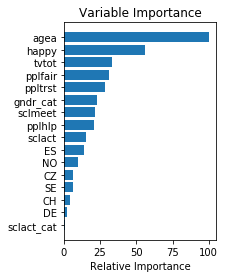

In [9]:
feature_importance = clf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [11]:
def run_model(estimators,depth,loss,subsample):
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
    params = {'n_estimators': estimators,
              'max_depth': depth,
              'loss': loss,'subsample':subsample}
    # Initialize and fit the model.
    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    predict_train = clf.predict(X_train)
    predict_test = clf.predict(X_test)

    # Accuracy tables.
    table_train = pd.crosstab(y_train, predict_train, margins=True)
    table_test = pd.crosstab(y_test, predict_test, margins=True)

    train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
    train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

    test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
    test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test,y_test)
    print("Train score: %0.6f, Test score: %0.6f" % (train_score,test_score))
    
    return train_score,test_score
    
  #Can focus on error type once parameters are narrowed down
  #  print((
  #      'Training set accuracy:\n'
  #      'Percent Type I errors: {}\n'
  #      'Percent Type II errors: {}\n\n'
  #      'Test set accuracy:\n'
  #      'Percent Type I errors: {}\n'
  #      'Percent Type II errors: {}'
  #  ).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

In [12]:
#Run model testing to match material output
run_model(500,2,"deviance",1)

Train score: 0.778096, Test score: 0.749693


(0.77809601745771961, 0.74969325153374233)

In [14]:
estimators_list=range(50,750,50)
max_depth_list = range(1,8)
loss_list = ("deviance","exponential")
subsample_list = (.1,.2,.3,.4,.5,.6,.7,.8,.9,1)

In [15]:
combination=0
comparison_table=pd.DataFrame(columns=("combination","train_score","test_score"))
for (estimators, depth, loss,subsample) in itertools.product(estimators_list, max_depth_list, loss_list,subsample_list):
    combination=combination+1
    print(combination)    
    print ("Parameters %0.f, %0.f, %0.1f" % (estimators,depth,subsample))
    print(loss)
    train_score,test_score =run_model(estimators,depth,loss,1) 
    comparison_table= comparison_table.append([{"combination":combination,"train_score":train_score,"test_score":test_score}])


1
Parameters 50, 1, 0.1
deviance
Train score: 0.742089, Test score: 0.727607
2
Parameters 50, 1, 0.2
deviance
Train score: 0.742089, Test score: 0.727607
3
Parameters 50, 1, 0.3
deviance
Train score: 0.742089, Test score: 0.727607
4
Parameters 50, 1, 0.4
deviance
Train score: 0.742089, Test score: 0.727607
5
Parameters 50, 1, 0.5
deviance
Train score: 0.742089, Test score: 0.727607
6
Parameters 50, 1, 0.6
deviance
Train score: 0.742089, Test score: 0.727607
7
Parameters 50, 1, 0.7
deviance
Train score: 0.742089, Test score: 0.727607
8
Parameters 50, 1, 0.8
deviance
Train score: 0.742089, Test score: 0.727607
9
Parameters 50, 1, 0.9
deviance
Train score: 0.742089, Test score: 0.727607
10
Parameters 50, 1, 1.0
deviance
Train score: 0.742089, Test score: 0.727607
11
Parameters 50, 1, 0.1
exponential
Train score: 0.740998, Test score: 0.731288
12
Parameters 50, 1, 0.2
exponential
Train score: 0.740998, Test score: 0.731288
13
Parameters 50, 1, 0.3
exponential
Train score: 0.740998, Test sc

Train score: 0.821877, Test score: 0.744785
105
Parameters 50, 6, 0.5
deviance
Train score: 0.821877, Test score: 0.744785
106
Parameters 50, 6, 0.6
deviance
Train score: 0.821877, Test score: 0.744785
107
Parameters 50, 6, 0.7
deviance
Train score: 0.821877, Test score: 0.744785
108
Parameters 50, 6, 0.8
deviance
Train score: 0.821877, Test score: 0.744785
109
Parameters 50, 6, 0.9
deviance
Train score: 0.821877, Test score: 0.744785
110
Parameters 50, 6, 1.0
deviance
Train score: 0.821877, Test score: 0.744785
111
Parameters 50, 6, 0.1
exponential
Train score: 0.816421, Test score: 0.750920
112
Parameters 50, 6, 0.2
exponential
Train score: 0.816421, Test score: 0.750920
113
Parameters 50, 6, 0.3
exponential
Train score: 0.816421, Test score: 0.752147
114
Parameters 50, 6, 0.4
exponential
Train score: 0.816421, Test score: 0.752147
115
Parameters 50, 6, 0.5
exponential
Train score: 0.816421, Test score: 0.750920
116
Parameters 50, 6, 0.6
exponential
Train score: 0.816421, Test score:

Train score: 0.791871, Test score: 0.754601
206
Parameters 100, 4, 0.6
deviance
Train score: 0.791871, Test score: 0.754601
207
Parameters 100, 4, 0.7
deviance
Train score: 0.791871, Test score: 0.754601
208
Parameters 100, 4, 0.8
deviance
Train score: 0.791871, Test score: 0.754601
209
Parameters 100, 4, 0.9
deviance
Train score: 0.791871, Test score: 0.754601
210
Parameters 100, 4, 1.0
deviance
Train score: 0.791871, Test score: 0.754601
211
Parameters 100, 4, 0.1
exponential
Train score: 0.789143, Test score: 0.752147
212
Parameters 100, 4, 0.2
exponential
Train score: 0.789143, Test score: 0.752147
213
Parameters 100, 4, 0.3
exponential
Train score: 0.789143, Test score: 0.752147
214
Parameters 100, 4, 0.4
exponential
Train score: 0.789143, Test score: 0.752147
215
Parameters 100, 4, 0.5
exponential
Train score: 0.789143, Test score: 0.752147
216
Parameters 100, 4, 0.6
exponential
Train score: 0.789143, Test score: 0.752147
217
Parameters 100, 4, 0.7
exponential
Train score: 0.7891

Train score: 0.765276, Test score: 0.744785
307
Parameters 150, 2, 0.7
deviance
Train score: 0.765276, Test score: 0.744785
308
Parameters 150, 2, 0.8
deviance
Train score: 0.765276, Test score: 0.744785
309
Parameters 150, 2, 0.9
deviance
Train score: 0.765276, Test score: 0.744785
310
Parameters 150, 2, 1.0
deviance
Train score: 0.765276, Test score: 0.744785
311
Parameters 150, 2, 0.1
exponential
Train score: 0.763366, Test score: 0.742331
312
Parameters 150, 2, 0.2
exponential
Train score: 0.763366, Test score: 0.742331
313
Parameters 150, 2, 0.3
exponential
Train score: 0.763366, Test score: 0.742331
314
Parameters 150, 2, 0.4
exponential
Train score: 0.763366, Test score: 0.742331
315
Parameters 150, 2, 0.5
exponential
Train score: 0.763366, Test score: 0.742331
316
Parameters 150, 2, 0.6
exponential
Train score: 0.763366, Test score: 0.742331
317
Parameters 150, 2, 0.7
exponential
Train score: 0.763366, Test score: 0.742331
318
Parameters 150, 2, 0.8
exponential
Train score: 0.7

Train score: 0.938625, Test score: 0.716564
408
Parameters 150, 7, 0.8
deviance
Train score: 0.939171, Test score: 0.732515
409
Parameters 150, 7, 0.9
deviance
Train score: 0.939034, Test score: 0.728834
410
Parameters 150, 7, 1.0
deviance
Train score: 0.935625, Test score: 0.725153
411
Parameters 150, 7, 0.1
exponential
Train score: 0.930033, Test score: 0.727607
412
Parameters 150, 7, 0.2
exponential
Train score: 0.930033, Test score: 0.726380
413
Parameters 150, 7, 0.3
exponential
Train score: 0.930851, Test score: 0.727607
414
Parameters 150, 7, 0.4
exponential
Train score: 0.930851, Test score: 0.730061
415
Parameters 150, 7, 0.5
exponential
Train score: 0.930033, Test score: 0.727607
416
Parameters 150, 7, 0.6
exponential
Train score: 0.930033, Test score: 0.727607
417
Parameters 150, 7, 0.7
exponential
Train score: 0.930851, Test score: 0.730061
418
Parameters 150, 7, 0.8
exponential
Train score: 0.930851, Test score: 0.723926
419
Parameters 150, 7, 0.9
exponential
Train score: 

Train score: 0.858565, Test score: 0.728834
509
Parameters 200, 5, 0.9
deviance
Train score: 0.858565, Test score: 0.727607
510
Parameters 200, 5, 1.0
deviance
Train score: 0.858565, Test score: 0.730061
511
Parameters 200, 5, 0.1
exponential
Train score: 0.853928, Test score: 0.743558
512
Parameters 200, 5, 0.2
exponential
Train score: 0.853928, Test score: 0.742331
513
Parameters 200, 5, 0.3
exponential
Train score: 0.853928, Test score: 0.741104
514
Parameters 200, 5, 0.4
exponential
Train score: 0.853928, Test score: 0.742331
515
Parameters 200, 5, 0.5
exponential
Train score: 0.853928, Test score: 0.743558
516
Parameters 200, 5, 0.6
exponential
Train score: 0.853928, Test score: 0.742331
517
Parameters 200, 5, 0.7
exponential
Train score: 0.853928, Test score: 0.742331
518
Parameters 200, 5, 0.8
exponential
Train score: 0.853928, Test score: 0.742331
519
Parameters 200, 5, 0.9
exponential
Train score: 0.853928, Test score: 0.742331
520
Parameters 200, 5, 1.0
exponential
Train scor

Train score: 0.792690, Test score: 0.743558
610
Parameters 250, 3, 1.0
deviance
Train score: 0.792690, Test score: 0.743558
611
Parameters 250, 3, 0.1
exponential
Train score: 0.788325, Test score: 0.752147
612
Parameters 250, 3, 0.2
exponential
Train score: 0.788325, Test score: 0.752147
613
Parameters 250, 3, 0.3
exponential
Train score: 0.788325, Test score: 0.752147
614
Parameters 250, 3, 0.4
exponential
Train score: 0.788325, Test score: 0.752147
615
Parameters 250, 3, 0.5
exponential
Train score: 0.788325, Test score: 0.752147
616
Parameters 250, 3, 0.6
exponential
Train score: 0.788325, Test score: 0.752147
617
Parameters 250, 3, 0.7
exponential
Train score: 0.788325, Test score: 0.752147
618
Parameters 250, 3, 0.8
exponential
Train score: 0.788325, Test score: 0.752147
619
Parameters 250, 3, 0.9
exponential
Train score: 0.788325, Test score: 0.752147
620
Parameters 250, 3, 1.0
exponential
Train score: 0.788325, Test score: 0.752147
621
Parameters 250, 4, 0.1
deviance
Train scor

Train score: 0.753955, Test score: 0.741104
711
Parameters 300, 1, 0.1
exponential
Train score: 0.754092, Test score: 0.737423
712
Parameters 300, 1, 0.2
exponential
Train score: 0.754092, Test score: 0.737423
713
Parameters 300, 1, 0.3
exponential
Train score: 0.754092, Test score: 0.737423
714
Parameters 300, 1, 0.4
exponential
Train score: 0.754092, Test score: 0.737423
715
Parameters 300, 1, 0.5
exponential
Train score: 0.754092, Test score: 0.737423
716
Parameters 300, 1, 0.6
exponential
Train score: 0.754092, Test score: 0.737423
717
Parameters 300, 1, 0.7
exponential
Train score: 0.754092, Test score: 0.737423
718
Parameters 300, 1, 0.8
exponential
Train score: 0.754092, Test score: 0.737423
719
Parameters 300, 1, 0.9
exponential
Train score: 0.754092, Test score: 0.737423
720
Parameters 300, 1, 1.0
exponential
Train score: 0.754092, Test score: 0.737423
721
Parameters 300, 2, 0.1
deviance
Train score: 0.772640, Test score: 0.748466
722
Parameters 300, 2, 0.2
deviance
Train scor

Train score: 0.936989, Test score: 0.719018
812
Parameters 300, 6, 0.2
exponential
Train score: 0.935215, Test score: 0.719018
813
Parameters 300, 6, 0.3
exponential
Train score: 0.936989, Test score: 0.721472
814
Parameters 300, 6, 0.4
exponential
Train score: 0.936989, Test score: 0.717791
815
Parameters 300, 6, 0.5
exponential
Train score: 0.936989, Test score: 0.721472
816
Parameters 300, 6, 0.6
exponential
Train score: 0.935215, Test score: 0.719018
817
Parameters 300, 6, 0.7
exponential
Train score: 0.936989, Test score: 0.719018
818
Parameters 300, 6, 0.8
exponential
Train score: 0.936989, Test score: 0.717791
819
Parameters 300, 6, 0.9
exponential
Train score: 0.936989, Test score: 0.719018
820
Parameters 300, 6, 1.0
exponential
Train score: 0.936989, Test score: 0.719018
821
Parameters 300, 7, 0.1
deviance
Train score: 0.988134, Test score: 0.707975
822
Parameters 300, 7, 0.2
deviance
Train score: 0.990044, Test score: 0.703067
823
Parameters 300, 7, 0.3
deviance
Train score: 

Train score: 0.834561, Test score: 0.736196
913
Parameters 350, 4, 0.3
exponential
Train score: 0.834561, Test score: 0.736196
914
Parameters 350, 4, 0.4
exponential
Train score: 0.834561, Test score: 0.736196
915
Parameters 350, 4, 0.5
exponential
Train score: 0.834561, Test score: 0.736196
916
Parameters 350, 4, 0.6
exponential
Train score: 0.834561, Test score: 0.736196
917
Parameters 350, 4, 0.7
exponential
Train score: 0.834561, Test score: 0.736196
918
Parameters 350, 4, 0.8
exponential
Train score: 0.834561, Test score: 0.736196
919
Parameters 350, 4, 0.9
exponential
Train score: 0.834561, Test score: 0.736196
920
Parameters 350, 4, 1.0
exponential
Train score: 0.834561, Test score: 0.736196
921
Parameters 350, 5, 0.1
deviance
Train score: 0.901255, Test score: 0.719018
922
Parameters 350, 5, 0.2
deviance
Train score: 0.901255, Test score: 0.719018
923
Parameters 350, 5, 0.3
deviance
Train score: 0.901255, Test score: 0.720245
924
Parameters 350, 5, 0.4
deviance
Train score: 0.9

Train score: 0.773732, Test score: 0.753374
1014
Parameters 400, 2, 0.4
exponential
Train score: 0.773732, Test score: 0.753374
1015
Parameters 400, 2, 0.5
exponential
Train score: 0.773732, Test score: 0.753374
1016
Parameters 400, 2, 0.6
exponential
Train score: 0.773732, Test score: 0.753374
1017
Parameters 400, 2, 0.7
exponential
Train score: 0.773732, Test score: 0.753374
1018
Parameters 400, 2, 0.8
exponential
Train score: 0.773732, Test score: 0.753374
1019
Parameters 400, 2, 0.9
exponential
Train score: 0.773732, Test score: 0.753374
1020
Parameters 400, 2, 1.0
exponential
Train score: 0.773732, Test score: 0.753374
1021
Parameters 400, 3, 0.1
deviance
Train score: 0.804146, Test score: 0.742331
1022
Parameters 400, 3, 0.2
deviance
Train score: 0.804146, Test score: 0.742331
1023
Parameters 400, 3, 0.3
deviance
Train score: 0.804146, Test score: 0.742331
1024
Parameters 400, 3, 0.4
deviance
Train score: 0.804146, Test score: 0.742331
1025
Parameters 400, 3, 0.5
deviance
Train s

Train score: 0.995908, Test score: 0.703067
1114
Parameters 400, 7, 0.4
exponential
Train score: 0.996999, Test score: 0.705521
1115
Parameters 400, 7, 0.5
exponential
Train score: 0.996999, Test score: 0.705521
1116
Parameters 400, 7, 0.6
exponential
Train score: 0.995908, Test score: 0.704294
1117
Parameters 400, 7, 0.7
exponential
Train score: 0.995908, Test score: 0.701840
1118
Parameters 400, 7, 0.8
exponential
Train score: 0.995908, Test score: 0.701840
1119
Parameters 400, 7, 0.9
exponential
Train score: 0.995908, Test score: 0.703067
1120
Parameters 400, 7, 1.0
exponential
Train score: 0.995908, Test score: 0.705521
1121
Parameters 450, 1, 0.1
deviance
Train score: 0.754228, Test score: 0.743558
1122
Parameters 450, 1, 0.2
deviance
Train score: 0.754228, Test score: 0.743558
1123
Parameters 450, 1, 0.3
deviance
Train score: 0.754228, Test score: 0.743558
1124
Parameters 450, 1, 0.4
deviance
Train score: 0.754228, Test score: 0.743558
1125
Parameters 450, 1, 0.5
deviance
Train s

Train score: 0.909711, Test score: 0.721472
1214
Parameters 450, 5, 0.4
exponential
Train score: 0.909711, Test score: 0.721472
1215
Parameters 450, 5, 0.5
exponential
Train score: 0.909711, Test score: 0.721472
1216
Parameters 450, 5, 0.6
exponential
Train score: 0.909711, Test score: 0.720245
1217
Parameters 450, 5, 0.7
exponential
Train score: 0.909711, Test score: 0.720245
1218
Parameters 450, 5, 0.8
exponential
Train score: 0.909711, Test score: 0.721472
1219
Parameters 450, 5, 0.9
exponential
Train score: 0.909711, Test score: 0.721472
1220
Parameters 450, 5, 1.0
exponential
Train score: 0.909711, Test score: 0.721472
1221
Parameters 450, 6, 0.1
deviance
Train score: 0.977360, Test score: 0.710429
1222
Parameters 450, 6, 0.2
deviance
Train score: 0.977360, Test score: 0.709202
1223
Parameters 450, 6, 0.3
deviance
Train score: 0.977360, Test score: 0.707975
1224
Parameters 450, 6, 0.4
deviance
Train score: 0.977360, Test score: 0.710429
1225
Parameters 450, 6, 0.5
deviance
Train s

Train score: 0.806738, Test score: 0.739877
1314
Parameters 500, 3, 0.4
exponential
Train score: 0.806738, Test score: 0.739877
1315
Parameters 500, 3, 0.5
exponential
Train score: 0.806738, Test score: 0.739877
1316
Parameters 500, 3, 0.6
exponential
Train score: 0.806738, Test score: 0.739877
1317
Parameters 500, 3, 0.7
exponential
Train score: 0.806738, Test score: 0.739877
1318
Parameters 500, 3, 0.8
exponential
Train score: 0.806738, Test score: 0.739877
1319
Parameters 500, 3, 0.9
exponential
Train score: 0.806738, Test score: 0.739877
1320
Parameters 500, 3, 1.0
exponential
Train score: 0.806738, Test score: 0.739877
1321
Parameters 500, 4, 0.1
deviance
Train score: 0.858974, Test score: 0.734969
1322
Parameters 500, 4, 0.2
deviance
Train score: 0.858974, Test score: 0.733742
1323
Parameters 500, 4, 0.3
deviance
Train score: 0.858974, Test score: 0.734969
1324
Parameters 500, 4, 0.4
deviance
Train score: 0.858974, Test score: 0.734969
1325
Parameters 500, 4, 0.5
deviance
Train s

Train score: 0.752319, Test score: 0.744785
1414
Parameters 550, 1, 0.4
exponential
Train score: 0.752319, Test score: 0.744785
1415
Parameters 550, 1, 0.5
exponential
Train score: 0.752319, Test score: 0.744785
1416
Parameters 550, 1, 0.6
exponential
Train score: 0.752319, Test score: 0.744785
1417
Parameters 550, 1, 0.7
exponential
Train score: 0.752319, Test score: 0.744785
1418
Parameters 550, 1, 0.8
exponential
Train score: 0.752319, Test score: 0.744785
1419
Parameters 550, 1, 0.9
exponential
Train score: 0.752319, Test score: 0.744785
1420
Parameters 550, 1, 1.0
exponential
Train score: 0.752319, Test score: 0.744785
1421
Parameters 550, 2, 0.1
deviance
Train score: 0.779596, Test score: 0.747239
1422
Parameters 550, 2, 0.2
deviance
Train score: 0.779596, Test score: 0.747239
1423
Parameters 550, 2, 0.3
deviance
Train score: 0.779596, Test score: 0.747239
1424
Parameters 550, 2, 0.4
deviance
Train score: 0.779596, Test score: 0.747239
1425
Parameters 550, 2, 0.5
deviance
Train s

Train score: 0.985816, Test score: 0.705521
1514
Parameters 550, 6, 0.4
exponential
Train score: 0.985816, Test score: 0.705521
1515
Parameters 550, 6, 0.5
exponential
Train score: 0.985816, Test score: 0.704294
1516
Parameters 550, 6, 0.6
exponential
Train score: 0.985679, Test score: 0.706748
1517
Parameters 550, 6, 0.7
exponential
Train score: 0.985816, Test score: 0.705521
1518
Parameters 550, 6, 0.8
exponential
Train score: 0.985816, Test score: 0.705521
1519
Parameters 550, 6, 0.9
exponential
Train score: 0.985816, Test score: 0.705521
1520
Parameters 550, 6, 1.0
exponential
Train score: 0.985816, Test score: 0.705521
1521
Parameters 550, 7, 0.1
deviance
Train score: 0.999591, Test score: 0.712883
1522
Parameters 550, 7, 0.2
deviance
Train score: 0.999864, Test score: 0.700613
1523
Parameters 550, 7, 0.3
deviance
Train score: 0.999864, Test score: 0.699387
1524
Parameters 550, 7, 0.4
deviance
Train score: 0.999864, Test score: 0.715337
1525
Parameters 550, 7, 0.5
deviance
Train s

Train score: 0.864294, Test score: 0.730061
1614
Parameters 600, 4, 0.4
exponential
Train score: 0.864294, Test score: 0.730061
1615
Parameters 600, 4, 0.5
exponential
Train score: 0.864294, Test score: 0.727607
1616
Parameters 600, 4, 0.6
exponential
Train score: 0.864294, Test score: 0.727607
1617
Parameters 600, 4, 0.7
exponential
Train score: 0.864294, Test score: 0.728834
1618
Parameters 600, 4, 0.8
exponential
Train score: 0.864294, Test score: 0.728834
1619
Parameters 600, 4, 0.9
exponential
Train score: 0.864294, Test score: 0.728834
1620
Parameters 600, 4, 1.0
exponential
Train score: 0.864294, Test score: 0.730061
1621
Parameters 600, 5, 0.1
deviance
Train score: 0.940262, Test score: 0.711656
1622
Parameters 600, 5, 0.2
deviance
Train score: 0.940262, Test score: 0.710429
1623
Parameters 600, 5, 0.3
deviance
Train score: 0.940262, Test score: 0.710429
1624
Parameters 600, 5, 0.4
deviance
Train score: 0.940262, Test score: 0.709202
1625
Parameters 600, 5, 0.5
deviance
Train s

Train score: 0.776459, Test score: 0.746012
1714
Parameters 650, 2, 0.4
exponential
Train score: 0.776459, Test score: 0.746012
1715
Parameters 650, 2, 0.5
exponential
Train score: 0.776459, Test score: 0.746012
1716
Parameters 650, 2, 0.6
exponential
Train score: 0.776459, Test score: 0.746012
1717
Parameters 650, 2, 0.7
exponential
Train score: 0.776459, Test score: 0.746012
1718
Parameters 650, 2, 0.8
exponential
Train score: 0.776459, Test score: 0.746012
1719
Parameters 650, 2, 0.9
exponential
Train score: 0.776459, Test score: 0.746012
1720
Parameters 650, 2, 1.0
exponential
Train score: 0.776459, Test score: 0.746012
1721
Parameters 650, 3, 0.1
deviance
Train score: 0.817376, Test score: 0.736196
1722
Parameters 650, 3, 0.2
deviance
Train score: 0.817376, Test score: 0.736196
1723
Parameters 650, 3, 0.3
deviance
Train score: 0.817376, Test score: 0.736196
1724
Parameters 650, 3, 0.4
deviance
Train score: 0.817376, Test score: 0.736196
1725
Parameters 650, 3, 0.5
deviance
Train s

Train score: 1.000000, Test score: 0.705521
1814
Parameters 650, 7, 0.4
exponential
Train score: 1.000000, Test score: 0.701840
1815
Parameters 650, 7, 0.5
exponential
Train score: 1.000000, Test score: 0.707975
1816
Parameters 650, 7, 0.6
exponential
Train score: 1.000000, Test score: 0.695706
1817
Parameters 650, 7, 0.7
exponential
Train score: 1.000000, Test score: 0.706748
1818
Parameters 650, 7, 0.8
exponential
Train score: 1.000000, Test score: 0.704294
1819
Parameters 650, 7, 0.9
exponential
Train score: 1.000000, Test score: 0.699387
1820
Parameters 650, 7, 1.0
exponential
Train score: 1.000000, Test score: 0.700613
1821
Parameters 700, 1, 0.1
deviance
Train score: 0.754774, Test score: 0.746012
1822
Parameters 700, 1, 0.2
deviance
Train score: 0.754774, Test score: 0.746012
1823
Parameters 700, 1, 0.3
deviance
Train score: 0.754774, Test score: 0.746012
1824
Parameters 700, 1, 0.4
deviance
Train score: 0.754774, Test score: 0.746012
1825
Parameters 700, 1, 0.5
deviance
Train s

Train score: 0.946263, Test score: 0.709202
1914
Parameters 700, 5, 0.4
exponential
Train score: 0.946263, Test score: 0.709202
1915
Parameters 700, 5, 0.5
exponential
Train score: 0.946263, Test score: 0.709202
1916
Parameters 700, 5, 0.6
exponential
Train score: 0.946263, Test score: 0.710429
1917
Parameters 700, 5, 0.7
exponential
Train score: 0.946263, Test score: 0.709202
1918
Parameters 700, 5, 0.8
exponential
Train score: 0.946263, Test score: 0.710429
1919
Parameters 700, 5, 0.9
exponential
Train score: 0.946263, Test score: 0.709202
1920
Parameters 700, 5, 1.0
exponential
Train score: 0.946263, Test score: 0.709202
1921
Parameters 700, 6, 0.1
deviance
Train score: 0.995908, Test score: 0.710429
1922
Parameters 700, 6, 0.2
deviance
Train score: 0.995908, Test score: 0.712883
1923
Parameters 700, 6, 0.3
deviance
Train score: 0.995908, Test score: 0.709202
1924
Parameters 700, 6, 0.4
deviance
Train score: 0.995908, Test score: 0.712883
1925
Parameters 700, 6, 0.5
deviance
Train s

In [16]:
print(comparison_table)

   combination  train_score  test_score
0            1     0.742089    0.727607
0            2     0.742089    0.727607
0            3     0.742089    0.727607
0            4     0.742089    0.727607
0            5     0.742089    0.727607
0            6     0.742089    0.727607
0            7     0.742089    0.727607
0            8     0.742089    0.727607
0            9     0.742089    0.727607
0           10     0.742089    0.727607
0           11     0.740998    0.731288
0           12     0.740998    0.731288
0           13     0.740998    0.731288
0           14     0.740998    0.731288
0           15     0.740998    0.731288
0           16     0.740998    0.731288
0           17     0.740998    0.731288
0           18     0.740998    0.731288
0           19     0.740998    0.731288
0           20     0.740998    0.731288
0           21     0.754637    0.732515
0           22     0.754637    0.732515
0           23     0.754637    0.732515
0           24     0.754637    0.732515


In [22]:
comparison_table.sort_values(by="test_score",ascending=False)

,combination,train_score,test_score
0,341,0.804555,0.758282
0,342,0.804555,0.758282
0,343,0.804555,0.758282
0,344,0.804555,0.758282
0,345,0.804555,0.758282
0,346,0.804555,0.758282
0,347,0.804555,0.758282
0,348,0.804555,0.758282
0,349,0.804555,0.758282
0,350,0.804555,0.758282


In [17]:
#Combination 102 Looks good, 3 depth, 700 estimators, .8 subsampling, exponential - .742331 Test, .81874 train scores.

In [18]:
# See if increasing estimators and depth helps, causes extreme overfitting.
run_model(1000,6,"exponential",.8)  

Train score: 1.000000, Test score: 0.706748


(1.0, 0.70674846625766874)

In [19]:
run_model(700,3,"exponential",.8)  

Train score: 0.820649, Test score: 0.726380


(0.82064920894708127, 0.72638036809815953)

In [20]:
print("\nNotebook Runtime:")
print("--- %s seconds ---" % (time.time() - notebook_start_time))


Notebook Runtime:
--- 6717.419740438461 seconds ---
